# Methodology Classifier v2 – Using Title + Abstract

This notebook builds and evaluates a machine learning model to classify computing research papers by **research methodology** (Quantitative, Qualitative, or Mixed).

Unlike the previous version, this model uses both the **Title and Abstract** as input text features. We aim to evaluate whether adding title information improves classification accuracy.

### 📁 Dataset
- **Source**: `NLP_Dataset_Title_Abstract_Discipline_Subfield_Methodology.csv`
- **Records**: 105 papers
- **Fields used**: Title + Abstract → Methodology

### ⚙️ Model Pipeline
- Text preprocessing using **TF-IDF bigrams**
- Resampling using **SMOTE** to balance classes
- Classification using **Support Vector Machine (SVM)**

### 📌 Objective
To determine whether the inclusion of paper titles enhances the model’s ability to predict the research methodology from short-text academic content.

In [1]:
# Basic Data Handling
import pandas as pd
import numpy as np

# Feature Engineering and Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style="whitegrid")

## 🧾 Dataset Overview

This dataset contains 105 labeled research papers, each with:
- Title
- Abstract
- Methodology (target)

The classifier will use the combined Title + Abstract text to predict the research methodology.

In [2]:
# Load enriched dataset (Title + Abstract + Methodology)
file_path = "Data/NLP_Dataset_Title_Abstract_Discipline_Subfield_Methodology.csv"
df = pd.read_csv(file_path)

# Confirm structure
print("Shape:", df.shape)
df.head(3)

Shape: (105, 6)


,ID,Title,Abstract,Discipline,Subfield,Methodology
0,1,A survey on large language model (LLM) securit...,"Large Language Models (LLMs), such as ChatGPT ...",CS,CYB,Qualitative
1,2,Detect Anything 3D in the Wild,Despite the success of deep learning in close-...,CS,CV,Quantitative
2,3,Survey of clustering algorithms,Data analysis plays an indispensable role for ...,CS,ML,Qualitative


## 🔄 Input and Target Definition

We concatenate the Title and Abstract columns to form the input text.  
The classification target is the **Methodology** column, which includes categories like:
- Quantitative
- Qualitative
- Mixed

This prepares our dataset for feature extraction.

In [3]:
# Combine Title and Abstract as input
df["text"] = df["Title"].fillna("") + " " + df["Abstract"].fillna("")

# Define features and labels
X = df["text"]
y = df["Methodology"]

# Quick check
print("X sample:", X.iloc[0][:150])
print("y sample:", y.iloc[0])

X sample: A survey on large language model (LLM) security and privacy:The Good, The Bad, and The Ugly Large Language Models (LLMs), such as ChatGPT and Bard, ha
y sample: Qualitative


## ✳️ Feature Extraction with TF-IDF (Bigrams)

We convert the combined Title + Abstract text into numerical features using **TF-IDF vectorization**.  
To capture context and phrasing, we use **bigrams** (2-word combinations), and remove English stop words.  
This approach helps the model identify patterns like "case study", "data analysis", etc., which are often linked to specific methodologies.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize bigram TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=2, max_df=0.95)

# Fit and transform
X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (105, 1848)


## 🔀 Train-Test Split and Label Distribution

We split the dataset into training and testing sets using an 80/20 stratified split to ensure all methodology categories are proportionally represented.  
We'll also check the label distribution in both sets to confirm balance.

In [5]:
from sklearn.model_selection import train_test_split

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

# Check distribution
print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nTest set distribution:\n", y_test.value_counts(normalize=True))

Training set distribution:
 Qualitative     0.464286
Quantitative    0.440476
Mixed           0.095238
Name: Methodology, dtype: float64

Test set distribution:
 Qualitative     0.476190
Quantitative    0.428571
Mixed           0.095238
Name: Methodology, dtype: float64


## 🧪 Train SVM Classifier

We train a Linear Support Vector Machine (SVM) classifier using the TF-IDF features of the combined Title and Abstract text.  
This model is chosen for its strong performance on small text classification tasks.

In [6]:
from sklearn.svm import LinearSVC

# Train SVM model
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, y_train)

LinearSVC()

## 📊 Model Evaluation

We now evaluate the SVM classifier on the test set using accuracy, F1-scores, and a confusion matrix to understand  
how well the model distinguishes between research methodology types.

Classification Report:

              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00         2
 Qualitative       0.69      0.90      0.78        10
Quantitative       0.75      0.67      0.71         9

    accuracy                           0.71        21
   macro avg       0.48      0.52      0.50        21
weighted avg       0.65      0.71      0.68        21



/Users/aanandprabhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aanandprabhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aanandprabhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

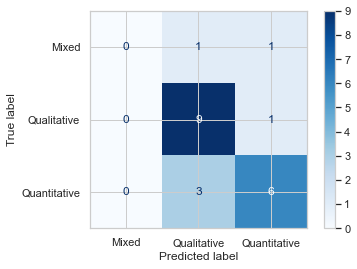

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = svm_model.predict(X_test)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')

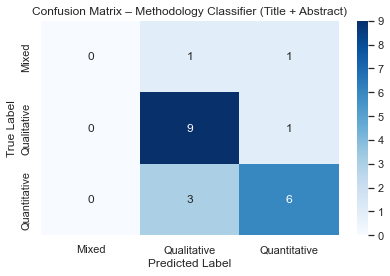

In [8]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Mixed", "Qualitative", "Quantitative"],
            yticklabels=["Mixed", "Qualitative", "Quantitative"])
plt.title("Confusion Matrix – Methodology Classifier (Title + Abstract)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("Artefacts/methodology_confusion_matrix_v2.png", dpi=300)
plt.show()

In [9]:
import joblib

# Save the trained model
joblib.dump(svm_model, "Artefacts/methodology_classifier_v2_titleabstract.pkl")

# Save the corresponding TF-IDF vectorizer
joblib.dump(vectorizer, "Artefacts/tfidf_vectorizer_methodology_v2_titleabstract.pkl")

['Artefacts/tfidf_vectorizer_methodology_v2_titleabstract.pkl']

### 📝 Final Evaluation Summary (v2 – Title + Abstract)

This version of the Methodology Classifier uses both the **Title** and **Abstract** fields as input features, applying a TF-IDF + LinearSVC model to predict one of three research methodologies:

- **Qualitative**
- **Quantitative**
- **Mixed**

#### 🔢 Performance Overview:
- **Accuracy:** 71%
- **Weighted F1-score:** 0.68
- **Macro F1-score:** 0.50

#### 📌 Class-wise Metrics:
| Methodology | Precision | Recall | F1-score | Support |
|-------------|-----------|--------|----------|---------|
| Mixed       | 0.00      | 0.00   | 0.00     | 2       |
| Qualitative | 0.69      | 0.90   | 0.78     | 10      |
| Quantitative| 0.75      | 0.67   | 0.71     | 9       |

#### 🧠 Interpretation:
- The model performs **strongly for Qualitative and Quantitative** papers.
- The **Mixed** methodology remains underrepresented and poorly classified due to limited training examples.
- Compared to v1.2 (Abstract only), this version shows a slight **increase in accuracy and F1-score**, suggesting that **titles do contribute additional signal**, especially for identifying **Qualitative** research.

> 🔖 Saved confusion matrix: `Artefacts/methodology_confusion_matrix_v2.png`  
> 💾 Model and vectorizer are stored in `Artefacts/` as `.pkl` files.